In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5

In [2]:
REGIONS = [['JH', 'Johor', 'JH'], 
           ['PH', 'Pahang', 'PH'],
           ['PRK', 'Perak', 'PRK'], 
           ['OtherPEN', 'Other Pen. States', 'OtherPEN'],
           ['PEN', 'Peninsula', 'Pmalay'],
           ['SBH', 'Sabah', 'SBH'],
           ['SWK', 'Sarawak', 'SWK']]

In [3]:
production = pd.read_csv('../palm_data/production_good.csv')
rainfall = pd.read_csv('../palm_data/rainfall_good.csv')
area = pd.read_csv('../palm_data/area_good.csv')

In [4]:
RAINFALL_LAGS = [6, 7, 8, 9, 10, 11, 12]
PRODUCTION_LAGS = [6, 7, 8, 9, 10, 11, 12]

In [5]:
def process_data(production, rainfall, area, REGIONS, PRODUCTION_LAGS, RAINFALL_LAGS):
    output = {}
    for i, region in enumerate(REGIONS):
        data = production[production.Region == region[0]]
        data = pd.merge(data[['Year', 'Month', 'Production', 'Diff_production']],
                        rainfall[rainfall.Region == region[1]][['Year', 'Month', 'Rainfall']], 
                        on=['Year', 'Month'], how='left')

        data = pd.merge(data, area[area.Region == region[2]][
            ['Year', 'Area_ma', 'Area_npa', 'Area_rpa', 'Area_New', 'Area_ma_new']], on='Year', how='left')
            
        data['Year'] = data['Year'].astype(int)
        data['Month'] = data['Month'].astype(int)
        data.reset_index(inplace=True)

        data.set_index([pd.to_datetime(['{0}-{1}-01'.format(x, y) for (x, y) in zip(data.Year, data.Month)])],
                       inplace=True)

        data.drop(['index', 'Year', 'Area_New', 'Diff_production'], axis=1, inplace=True)
        data['Time'] = np.arange(len(data))

        for lag in RAINFALL_LAGS:
            temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Rainfall.values[:-lag]))
            data['Rainfall_{0}'.format(lag)] = temp

        for lag in PRODUCTION_LAGS:
            temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Production.values[:-lag]))
            data['Production_{0}'.format(lag)] = temp
        
        PRODUCTION = data.Production
        data.drop(['Production'], axis=1, inplace=True)

        data.fillna(data.mean(), inplace=True)

        #  And finally drop rainfalls
        data.drop(['Rainfall'], axis=1, inplace=True)
        ### HERE I CAN ADD FEATURE ENGINEERING!!!

        #  And clip first year
        for col in data.columns:
            data['_'.join([region[1], str(col)])] = data[col]
            data.drop([col], axis=1, inplace=True)
        
        output[region[1]] = (data[max(PRODUCTION_LAGS):], PRODUCTION[max(PRODUCTION_LAGS):])
    return output


In [14]:
DATA = process_data(production, rainfall, area, REGIONS, PRODUCTION_LAGS, RAINFALL_LAGS)
DATA['Peninsula']

(            Peninsula_Month  Peninsula_Area_ma  Peninsula_Area_npa  \
 1999-01-01                1        1856.000000         2052.000000   
 1999-02-01                2        1856.000000         2052.000000   
 1999-03-01                3        1856.000000         2052.000000   
 1999-04-01                4        1856.000000         2052.000000   
 1999-05-01                5        1856.000000         2052.000000   
 ...                     ...                ...                 ...   
 2017-05-01                5        2081.210526         2360.157895   
 2017-06-01                6        2081.210526         2360.157895   
 2017-07-01                7        2081.210526         2360.157895   
 2017-08-01                8        2081.210526         2360.157895   
 2017-09-01                9        2081.210526         2360.157895   
 
             Peninsula_Area_rpa  Peninsula_Area_ma_new  Peninsula_Time  \
 1999-01-01           22.000000            1130.630769              12  

<AxesSubplot:>

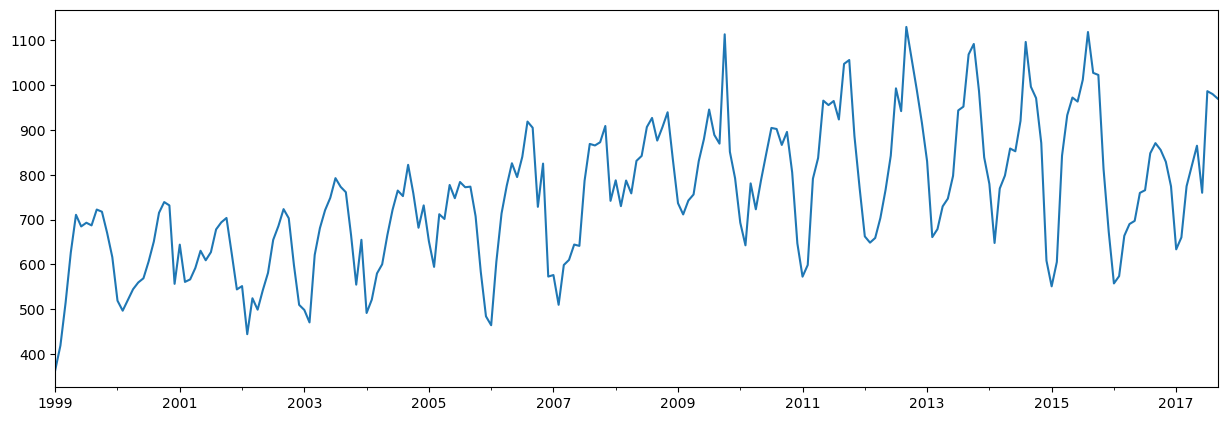

In [15]:
ts = DATA['Peninsula'][1]
ts.plot()

In [16]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, RepeatVector
from keras.layers import LSTM
from keras.optimizers import Adam, Adagrad

from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperopt import Trials, STATUS_OK, tpe, rand

In [17]:
values = np.concatenate((DATA['Peninsula'][0].values, DATA['Peninsula'][1].values.reshape((-1, 1))), axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)

In [18]:
VALIDATION_SHIFT = 12
EPOCHS = 200

train = values[:-VALIDATION_SHIFT, :]
test = values[-VALIDATION_SHIFT:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

optimizer = Adagrad(0.01)

Epoch 1/200
4/4 - 0s - loss: 0.2772 - val_loss: 0.3543
Epoch 2/200
4/4 - 0s - loss: 0.2436 - val_loss: 0.2949
Epoch 3/200
4/4 - 0s - loss: 0.1973 - val_loss: 0.2399
Epoch 4/200
4/4 - 0s - loss: 0.1608 - val_loss: 0.1903
Epoch 5/200
4/4 - 0s - loss: 0.1231 - val_loss: 0.1465
Epoch 6/200
4/4 - 0s - loss: 0.0926 - val_loss: 0.1088
Epoch 7/200
4/4 - 0s - loss: 0.0640 - val_loss: 0.0774
Epoch 8/200
4/4 - 0s - loss: 0.0455 - val_loss: 0.0529
Epoch 9/200
4/4 - 0s - loss: 0.0396 - val_loss: 0.0347
Epoch 10/200
4/4 - 0s - loss: 0.0272 - val_loss: 0.0224
Epoch 11/200
4/4 - 0s - loss: 0.0266 - val_loss: 0.0148
Epoch 12/200
4/4 - 0s - loss: 0.0239 - val_loss: 0.0109
Epoch 13/200
4/4 - 0s - loss: 0.0249 - val_loss: 0.0093
Epoch 14/200
4/4 - 0s - loss: 0.0284 - val_loss: 0.0090
Epoch 15/200
4/4 - 0s - loss: 0.0259 - val_loss: 0.0095
Epoch 16/200
4/4 - 0s - loss: 0.0259 - val_loss: 0.0104
Epoch 17/200
4/4 - 0s - loss: 0.0226 - val_loss: 0.0118
Epoch 18/200
4/4 - 0s - loss: 0.0222 - val_loss: 0.0133
E

Epoch 147/200
4/4 - 0s - loss: 0.0127 - val_loss: 0.0159
Epoch 148/200
4/4 - 0s - loss: 0.0143 - val_loss: 0.0157
Epoch 149/200
4/4 - 0s - loss: 0.0118 - val_loss: 0.0159
Epoch 150/200
4/4 - 0s - loss: 0.0130 - val_loss: 0.0148
Epoch 151/200
4/4 - 0s - loss: 0.0128 - val_loss: 0.0135
Epoch 152/200
4/4 - 0s - loss: 0.0135 - val_loss: 0.0135
Epoch 153/200
4/4 - 0s - loss: 0.0115 - val_loss: 0.0141
Epoch 154/200
4/4 - 0s - loss: 0.0142 - val_loss: 0.0146
Epoch 155/200
4/4 - 0s - loss: 0.0152 - val_loss: 0.0147
Epoch 156/200
4/4 - 0s - loss: 0.0109 - val_loss: 0.0155
Epoch 157/200
4/4 - 0s - loss: 0.0115 - val_loss: 0.0162
Epoch 158/200
4/4 - 0s - loss: 0.0143 - val_loss: 0.0157
Epoch 159/200
4/4 - 0s - loss: 0.0134 - val_loss: 0.0144
Epoch 160/200
4/4 - 0s - loss: 0.0128 - val_loss: 0.0140
Epoch 161/200
4/4 - 0s - loss: 0.0133 - val_loss: 0.0148
Epoch 162/200
4/4 - 0s - loss: 0.0129 - val_loss: 0.0160
Epoch 163/200
4/4 - 0s - loss: 0.0117 - val_loss: 0.0160
Epoch 164/200
4/4 - 0s - loss: 

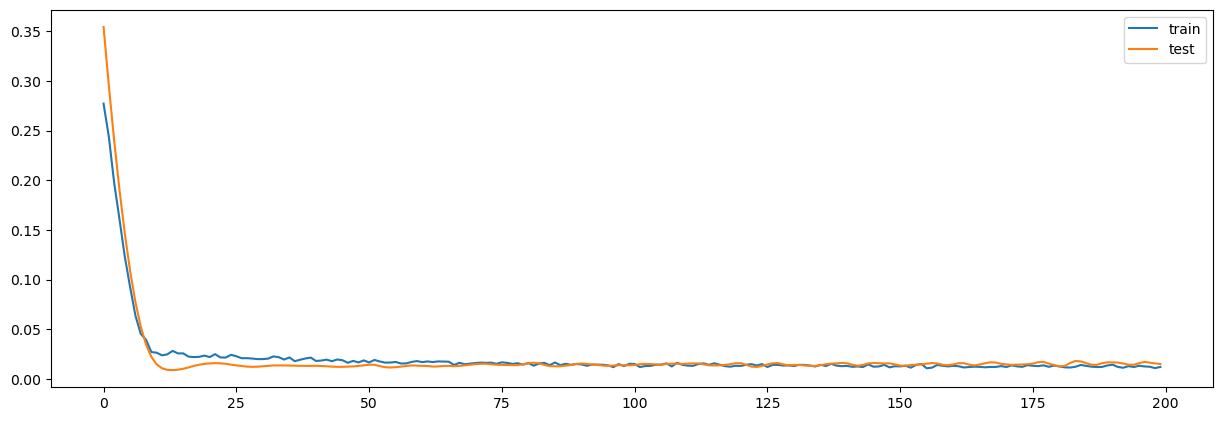

In [28]:
# reshape input to be 3D [samples, features, timesteps]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))
# model.compile(loss='mae', optimizer=optimizer)
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, 
                    epochs=EPOCHS, batch_size=64, 
                    validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
yhat = model.predict(test_X)
yhat[yhat<0] = 0
yhat_train = model.predict(train_X)
yhat_train[yhat_train<0] = 0

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))

Test RMSE: 94.492
Actual data:  [855.692 829.251 774.394 633.767 660.446 774.698 820.077 865.067 760.05
 986.796 980.377 970.19 ]
Forecast:  [894.04304752 810.84262433 717.01480295 593.48186861 593.75763928
 639.83394221 679.77831984 710.25522543 763.81550613 841.59507231
 885.25888407 907.03965367]


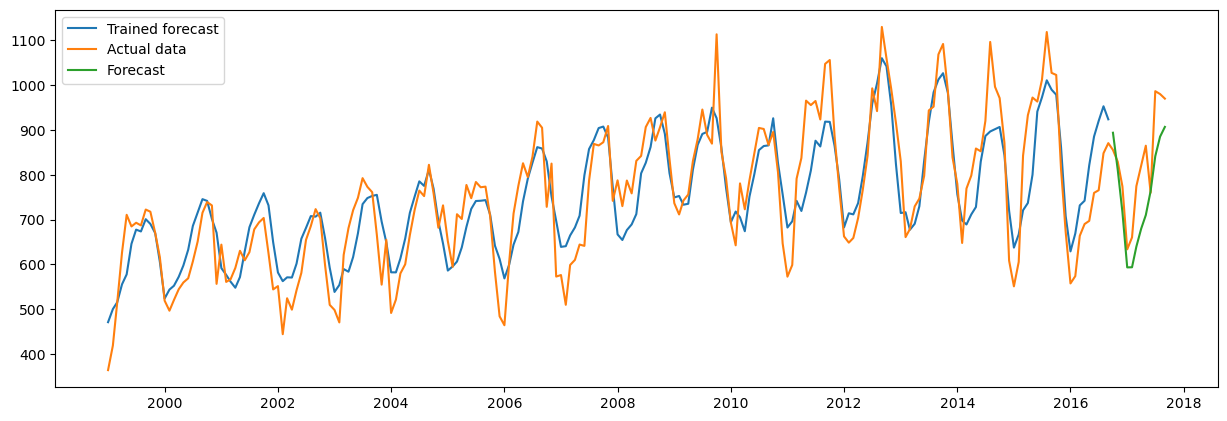

In [29]:
# invert scaling for training
inv_yhat_train = np.concatenate((train_X, yhat_train), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,-1]


# invert scaling for forecast
inv_yhat = np.concatenate((test_X, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]


# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print("Actual data: ", inv_y)
print("Forecast: ",inv_yhat)

plt.plot(pd.Series(inv_yhat_train, index=DATA['Peninsula'][1].index[:-VALIDATION_SHIFT]), label="Trained forecast")
plt.plot(DATA['Peninsula'][1], label="Actual data")
plt.plot(pd.Series(inv_yhat, index=DATA['Peninsula'][1].index[-VALIDATION_SHIFT:]), label="Forecast")
plt.legend()

Epoch 1/200
4/4 - 0s - loss: 0.2241 - val_loss: 0.0738
Epoch 2/200
4/4 - 0s - loss: 0.0362 - val_loss: 0.0263
Epoch 3/200
4/4 - 0s - loss: 0.0239 - val_loss: 0.0200
Epoch 4/200
4/4 - 0s - loss: 0.0231 - val_loss: 0.0189
Epoch 5/200
4/4 - 0s - loss: 0.0226 - val_loss: 0.0185
Epoch 6/200
4/4 - 0s - loss: 0.0221 - val_loss: 0.0183
Epoch 7/200
4/4 - 0s - loss: 0.0217 - val_loss: 0.0182
Epoch 8/200
4/4 - 0s - loss: 0.0213 - val_loss: 0.0181
Epoch 9/200
4/4 - 0s - loss: 0.0209 - val_loss: 0.0180
Epoch 10/200
4/4 - 0s - loss: 0.0205 - val_loss: 0.0179
Epoch 11/200
4/4 - 0s - loss: 0.0201 - val_loss: 0.0178
Epoch 12/200
4/4 - 0s - loss: 0.0198 - val_loss: 0.0177
Epoch 13/200
4/4 - 0s - loss: 0.0195 - val_loss: 0.0177
Epoch 14/200
4/4 - 0s - loss: 0.0191 - val_loss: 0.0177
Epoch 15/200
4/4 - 0s - loss: 0.0188 - val_loss: 0.0177
Epoch 16/200
4/4 - 0s - loss: 0.0185 - val_loss: 0.0176
Epoch 17/200
4/4 - 0s - loss: 0.0183 - val_loss: 0.0176
Epoch 18/200
4/4 - 0s - loss: 0.0180 - val_loss: 0.0176
E

Epoch 147/200
4/4 - 0s - loss: 0.0095 - val_loss: 0.0186
Epoch 148/200
4/4 - 0s - loss: 0.0095 - val_loss: 0.0186
Epoch 149/200
4/4 - 0s - loss: 0.0095 - val_loss: 0.0186
Epoch 150/200
4/4 - 0s - loss: 0.0095 - val_loss: 0.0186
Epoch 151/200
4/4 - 0s - loss: 0.0095 - val_loss: 0.0185
Epoch 152/200
4/4 - 0s - loss: 0.0095 - val_loss: 0.0186
Epoch 153/200
4/4 - 0s - loss: 0.0094 - val_loss: 0.0185
Epoch 154/200
4/4 - 0s - loss: 0.0094 - val_loss: 0.0186
Epoch 155/200
4/4 - 0s - loss: 0.0094 - val_loss: 0.0185
Epoch 156/200
4/4 - 0s - loss: 0.0094 - val_loss: 0.0186
Epoch 157/200
4/4 - 0s - loss: 0.0094 - val_loss: 0.0185
Epoch 158/200
4/4 - 0s - loss: 0.0094 - val_loss: 0.0185
Epoch 159/200
4/4 - 0s - loss: 0.0094 - val_loss: 0.0186
Epoch 160/200
4/4 - 0s - loss: 0.0094 - val_loss: 0.0185
Epoch 161/200
4/4 - 0s - loss: 0.0093 - val_loss: 0.0185
Epoch 162/200
4/4 - 0s - loss: 0.0093 - val_loss: 0.0186
Epoch 163/200
4/4 - 0s - loss: 0.0093 - val_loss: 0.0185
Epoch 164/200
4/4 - 0s - loss: 

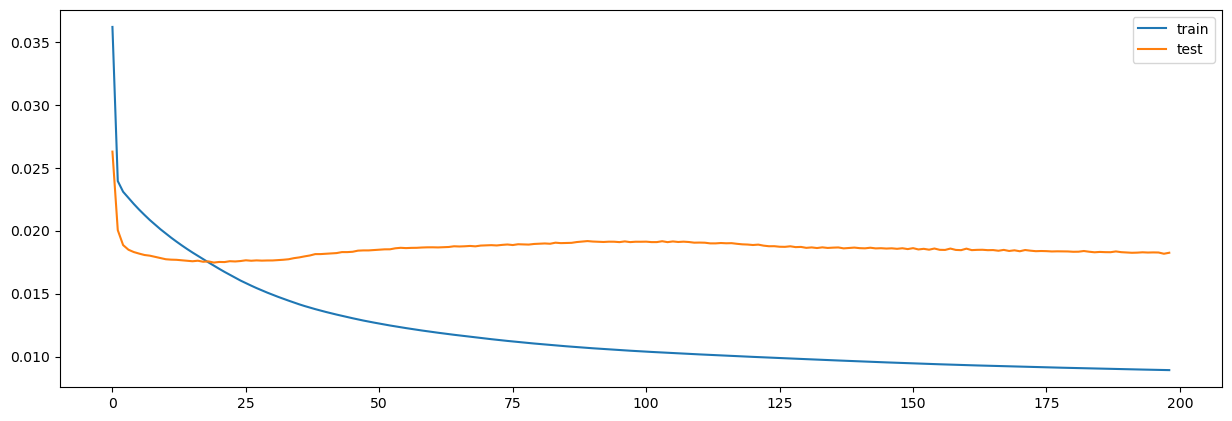

In [32]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', 
                     input_shape=(train_X.shape[1], train_X.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=optimizer)

history = model_cnn.fit(train_X, train_y, 
                        epochs=EPOCHS, batch_size=64, 
                        validation_data=(test_X, test_y), 
                        verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'][1:], label='train')
plt.plot(history.history['val_loss'][1:], label='test')
plt.legend()
plt.show()

# make a prediction
yhat = model_cnn.predict(test_X)
yhat[yhat<0] = 0
yhat_train = model_cnn.predict(train_X)
yhat_train[yhat_train<0] = 0

test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1]))

Test RMSE: 106.545
Actual data:  [855.692 829.251 774.394 633.767 660.446 774.698 820.077 865.067 760.05
 986.796 980.377 970.19 ]
Forecast:  [856.62443706 774.42286073 682.58042839 611.53898076 611.37847218
 622.04572929 666.49188054 695.79924909 737.92381305 816.99842845
 871.1112093  898.91647235]


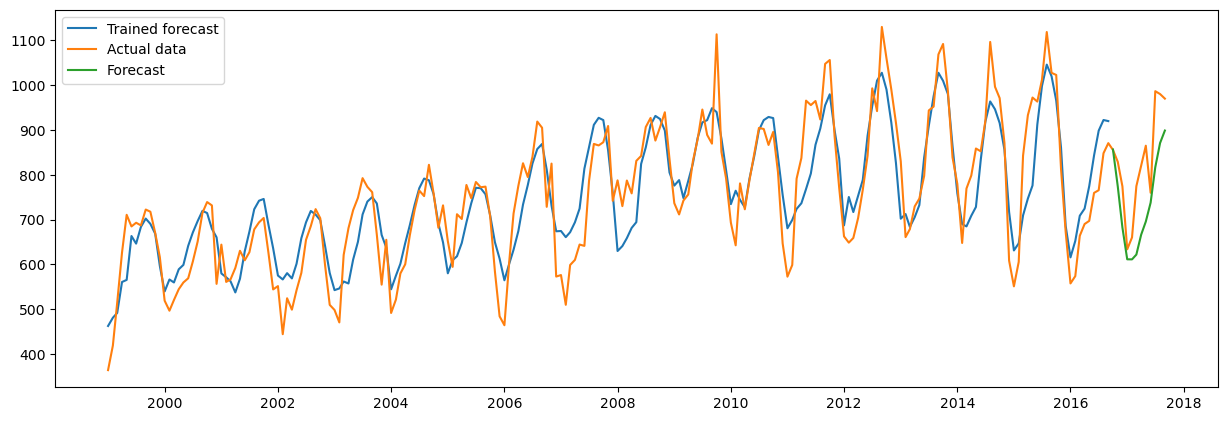

In [31]:
# invert scaling for training
inv_yhat_train = np.concatenate((train_X, yhat_train), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,-1]


# invert scaling for forecast
inv_yhat = np.concatenate((test_X, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]


# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print("Actual data: ", inv_y)
print("Forecast: ",inv_yhat)

plt.plot(pd.Series(inv_yhat_train, index=DATA['Peninsula'][1].index[:-VALIDATION_SHIFT]), label="Trained forecast")
plt.plot(DATA['Peninsula'][1], label="Actual data")
plt.plot(pd.Series(inv_yhat, index=DATA['Peninsula'][1].index[-VALIDATION_SHIFT:]), label="Forecast")
plt.legend()